### Task

In [1]:
from zlib import crc32
import numpy as np

types = ['regression', 'classification']
datasets = {'regression': [{'name': 'Servo Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'}, 
                           {'name': 'Forest Fires Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
                           {'name': 'Boston Housing Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston'}, 
                           {'name': 'Diabetes Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes'}],
            'classification': [{'name': 'Spambase Data Set',
                                'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'}, 
                               {'name': 'Wine Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine'}, 
                               {'name': 'Breast Cancer Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'}, 
                               {'name': 'MNIST',
                                'url': 'http://yann.lecun.com/exdb/mnist/'}]}
methods = {'regression': ['Линейная регрессия', 
                          'Нейронная сеть (Перцептрон)', 
                          'Надарая-Ватсона',
                          'SVR'],
           'classification': ['Логистическая регрессия', 
                              'Нейронная сеть (Перцептрон)', 
                              'k-ближайших соседей',
                              'Метод потенциальных функций',
                              'Метод парзеновского окна', 
                              'SVM']}
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
task['id'] = crc32(task['mail'].encode('utf-8'))
np.random.seed(task['id'])
task['type'] = np.random.choice(types)
task['dataset'] = np.random.choice(datasets[task['type']])
task['method'] = np.random.choice(methods[task['type']], size=2, replace=False).tolist()

task

Enter your mail: alan_gassiev@mail.ru


{'mail': 'alan_gassiev@mail.ru',
 'id': 1539474777,
 'type': 'classification',
 'dataset': {'name': 'Spambase Data Set',
  'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'},
 'method': ['k-ближайших соседей', 'SVM']}

### Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mlxtend.plotting import plot_decision_regions
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn
import random
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid

### Dataset info

E-mail classification: spam or not spam

#### Attributes info

* 48 real (from 0 to 100 inclusive) attributes of type word_freq_WORD = percentage of WORD in the e-mail.
* 6 real (from 0 to 100 inclusive) attributes of type char_freq_CHAR = percentage of CHAR in the e-mail.
* 1 real (no less than 1) attribute of type capital_run_length_average = average length of uninterrupted sequences of capital letters
* 1 integer (no less than 1) attribute of type capital_run_length_longest = length of longest uninterrupted sequence of capital letters
* 1 integer (no less than 1) attribute of type capital_run_length_total = total number of capital letters in the e-mail
* 1 integer (0 or 1) attribute of type spam = spam indicator

### Parsing .names file, getting attributes' names

In [3]:
column_names = []
with open('spambase/spambase.names') as f:
    column_names = list(l.split(':')[0] for l in f.read().split('\n')[-58:-1])
column_names.append('is_spam')

### Parsing and analyzing dataset

In [4]:
data = pd.read_csv('spambase/spambase.data', names = column_names)
data.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [5]:
X = data[column_names[:-1]].to_numpy()
Y = data['is_spam'].to_numpy()
entities_number = len(X)

In [6]:
X_log = np.log(np.ones_like(X) + X) # log values to neutralize exponential distribution
X_normalized = MinMaxScaler().fit_transform(X_log) # normalize values with MinMaxScaler
data_normalized = data.copy()
data_normalized[column_names[:-1]] = pd.DataFrame(X_normalized)

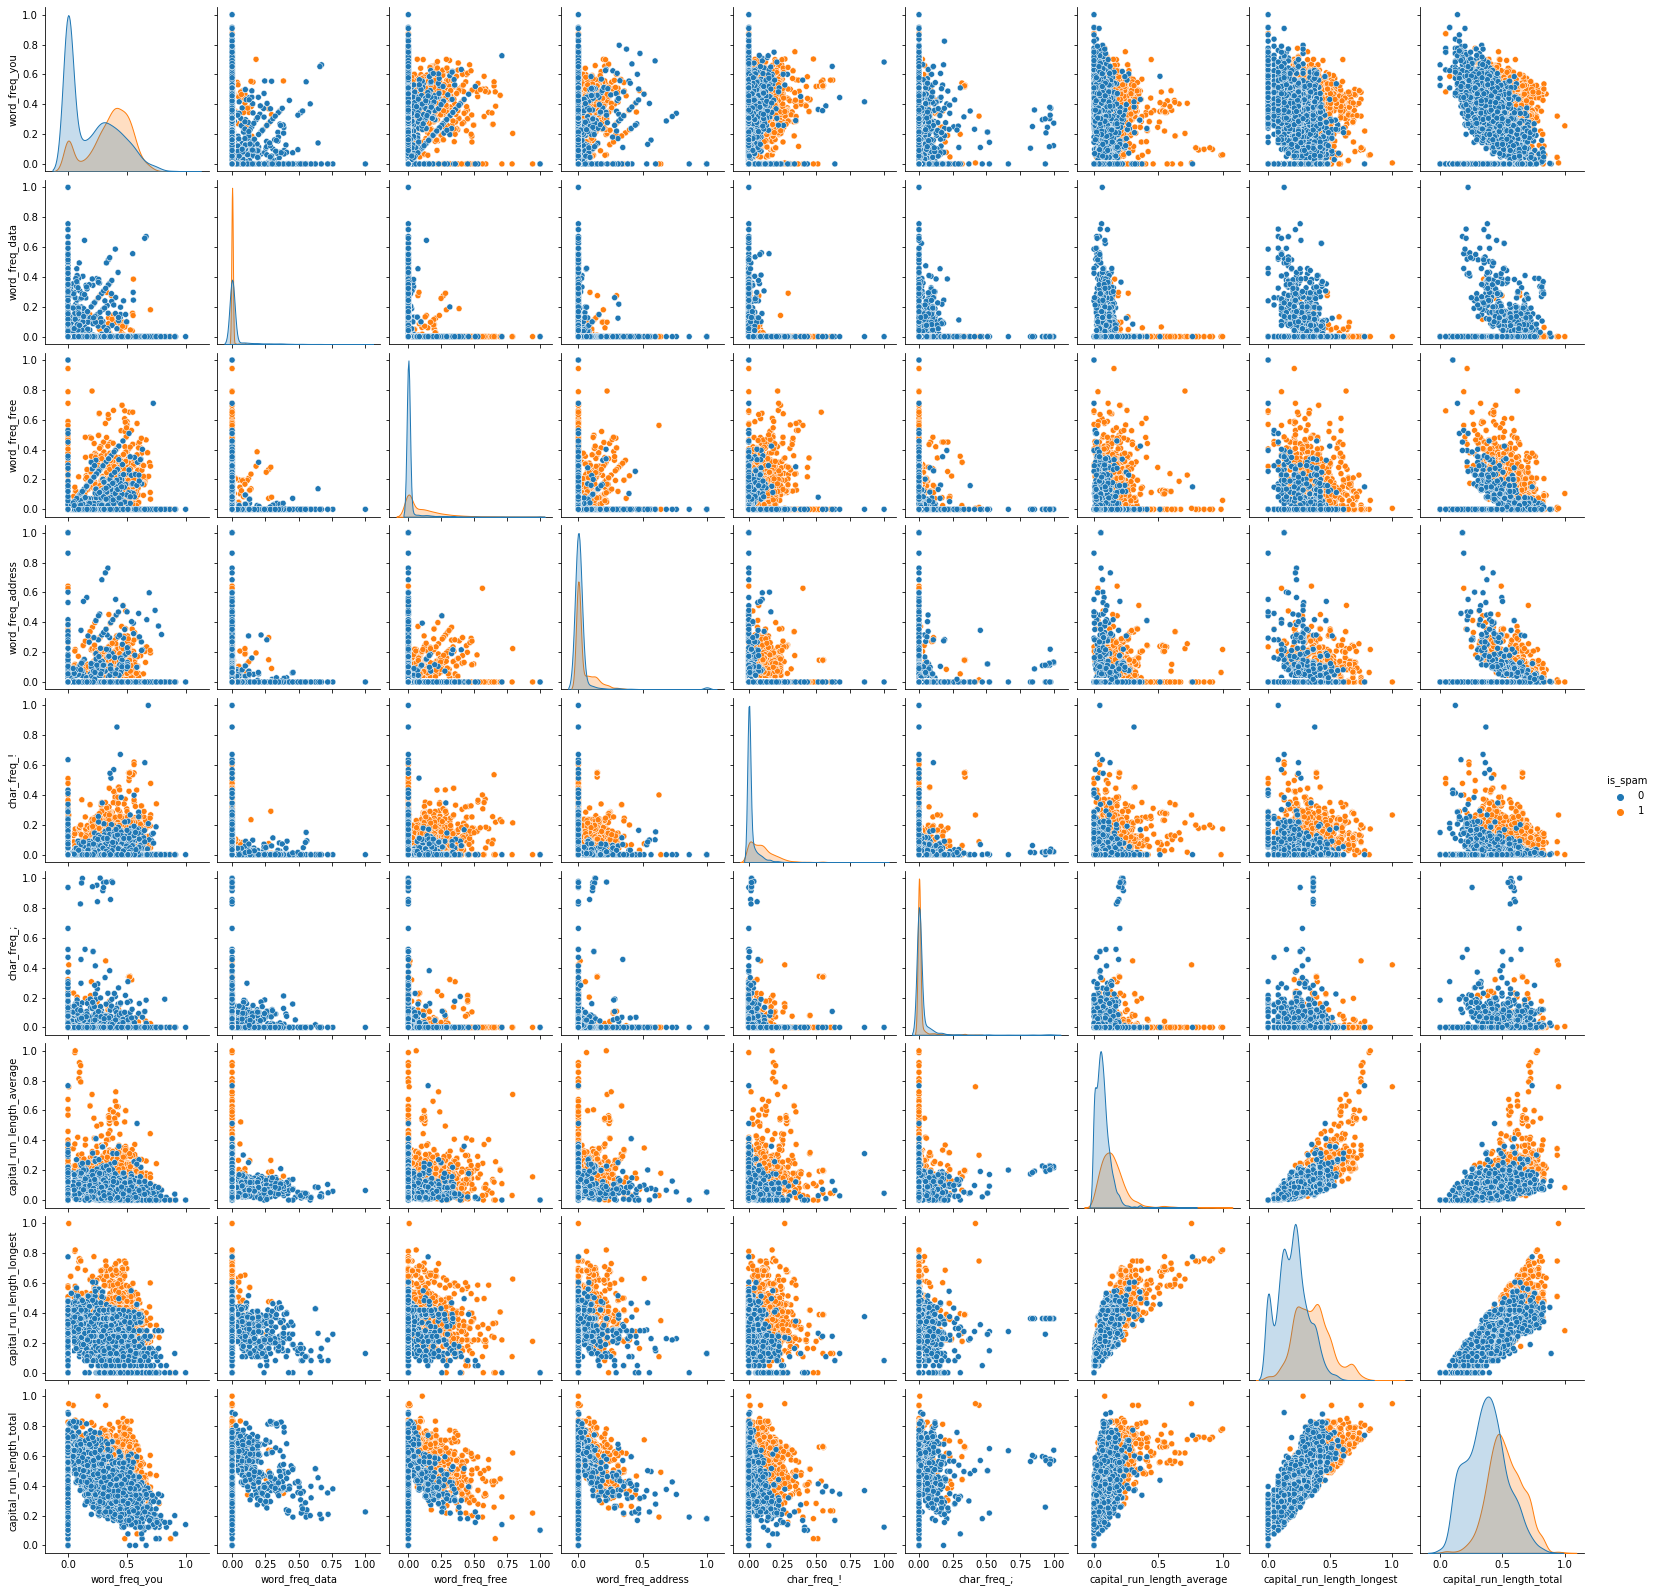

In [7]:
# visualizing dependencies
columns_for_plot = random.choices(column_names[:48], k=4) # random words
columns_for_plot += random.choices(column_names[48:54], k=2) # random characters
columns_for_plot += column_names[54:] # add last unique attributes 
seaborn.pairplot(data_normalized[columns_for_plot], hue='is_spam')
plt.show()

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0) # test_size defaults to 0.25

### kNN

In [9]:
models = []
for k in range(1, 50):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, Y_train)
    models.append(model)

In [10]:
for k in range(1, 26):
    res = models[k-1].predict(X_test)
    tn, fp, fn, tp = confusion_matrix(res, Y_test).ravel()
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    print(f'k={k:02d}, prec={prec:0.4f}, rec={rec:0.4f}, acc={acc:0.4f}')

k=01, prec=0.7435, rec=0.7862, acc=0.8167
k=02, prec=0.5717, rec=0.8457, acc=0.7871
k=03, prec=0.7196, rec=0.7680, acc=0.8010
k=04, prec=0.6391, rec=0.8212, acc=0.8002
k=05, prec=0.7261, rec=0.7915, acc=0.8141
k=06, prec=0.6478, rec=0.8466, acc=0.8123
k=07, prec=0.7304, rec=0.7962, acc=0.8175
k=08, prec=0.6565, rec=0.8118, acc=0.8019
k=09, prec=0.7065, rec=0.7701, acc=0.7984
k=10, prec=0.6370, rec=0.7898, acc=0.7871
k=11, prec=0.6717, rec=0.7555, acc=0.7819
k=12, prec=0.6217, rec=0.7709, acc=0.7750
k=13, prec=0.6696, rec=0.7643, acc=0.7854
k=14, prec=0.6391, rec=0.7840, acc=0.7854
k=15, prec=0.6891, rec=0.7566, acc=0.7871
k=16, prec=0.6326, rec=0.7638, acc=0.7750
k=17, prec=0.6696, rec=0.7568, acc=0.7819
k=18, prec=0.6304, rec=0.7572, acc=0.7715
k=19, prec=0.6500, rec=0.7293, acc=0.7637
k=20, prec=0.6174, rec=0.7553, acc=0.7672
k=21, prec=0.6587, rec=0.7519, acc=0.7767
k=22, prec=0.6174, rec=0.7533, acc=0.7663
k=23, prec=0.6435, rec=0.7309, acc=0.7628
k=24, prec=0.6217, rec=0.7467, acc

### SVM

In [11]:
param_grid = [
    {'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}, # use default C (and gamma), compare kernels
    {'C': [1e-1, 1, 1e1], 'kernel': ['linear']}, # compare different C values with linear classifier
    {'gamma': [0.001, 'scale'], 'kernel': ['rbf', 'poly', 'sigmoid']}, # compare 
]
params_list = list(ParameterGrid(param_grid))

In [12]:
for params in params_list:
    model = SVC(**params)
    model.fit(X_train, Y_train)
    res = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(res, Y_test).ravel()
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    print(f'params={params}, prec={prec:0.4f}, rec={rec:0.4f}, acc={acc:0.4f}')

params={'kernel': 'linear'}, prec=0.8652, rec=0.9171, acc=0.9149
params={'kernel': 'rbf'}, prec=0.4370, rec=0.7976, acc=0.7307
params={'kernel': 'poly'}, prec=0.1348, rec=0.8986, acc=0.6481
params={'kernel': 'sigmoid'}, prec=0.5022, rec=0.5620, acc=0.6447
params={'C': 0.1, 'kernel': 'linear'}, prec=0.8609, rec=0.9000, acc=0.9062
params={'C': 1, 'kernel': 'linear'}, prec=0.8652, rec=0.9171, acc=0.9149
params={'C': 10.0, 'kernel': 'linear'}, prec=0.8739, rec=0.8855, acc=0.9044
params={'gamma': 0.001, 'kernel': 'rbf'}, prec=0.7239, rec=0.7910, acc=0.8132
params={'gamma': 0.001, 'kernel': 'poly'}, prec=0.8130, rec=0.8386, acc=0.8627
params={'gamma': 0.001, 'kernel': 'sigmoid'}, prec=0.1804, rec=0.1704, acc=0.3215
params={'gamma': 'scale', 'kernel': 'rbf'}, prec=0.4370, rec=0.7976, acc=0.7307
params={'gamma': 'scale', 'kernel': 'poly'}, prec=0.1348, rec=0.8986, acc=0.6481
params={'gamma': 'scale', 'kernel': 'sigmoid'}, prec=0.5022, rec=0.5620, acc=0.6447


### Conclusion

* kNN works better with small k. It requires less than a second.
* SVM is better with linear kernel. It trains during several seconds or even minutes in some cases
* SVM shows much better results (metrics' difference is about 0.15 in average), although it works much slower. But it is hard to discuss time as the used dataset is relatively small.